###**0. Imports e connect à Google Drive**

In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import re
from PIL import Image
import cv2
import copy
import zipfile
import gdown
import albumentations as A
import random
import datetime
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# este comando é usado para mudar a diretória atual para o dataset
%cd /content/drive/MyDrive/Mars_Capstone_Project/MarsSampleLocalization_Dataset

/content/drive/MyDrive/Mars_Capstone_Project/MarsSampleLocalization_Dataset


#**Preprocessing para o modelo da bounding box (regressão)**

###**Primeiro foi tudo feito para as imagens reais do dataset e só depois juntámos as imagens sintéticas processadas. Por isso é que algumas funções criadas inicialmente foram posteriormente adaptadas para as imagens sintéticas**


## **Primeiro passo**: Mudar as paths das imagens para algo diretamente acessível





In [4]:
def list_from_darknetlabels(image_type, set_type):

  f = open('./train_images/darknet_labels/' + image_type + '_' + set_type + '.txt', 'r')
  lines_list = f.readlines()
  f.close()

  vector = []

  for line in lines_list:

      my_regex = re.compile("((?<=datasets/).*).png")   # positive lookbehind
      m_1 = my_regex.search(line)
      m_2 = m_1.group(0)
      path = './' + m_2
      vector.append(path)

  return vector

In [5]:
# usa-se a função acima para as imagens reais de treino e de validação, respetivamente

real_train_list = list_from_darknetlabels('real', 'train')
real_valid_list = list_from_darknetlabels('real', 'valid')
real_train_list[:2]

['./train_images/real/train/Treal_N1.png',
 './train_images/real/train/Treal_N2.png']

PNG (1024, 768) L


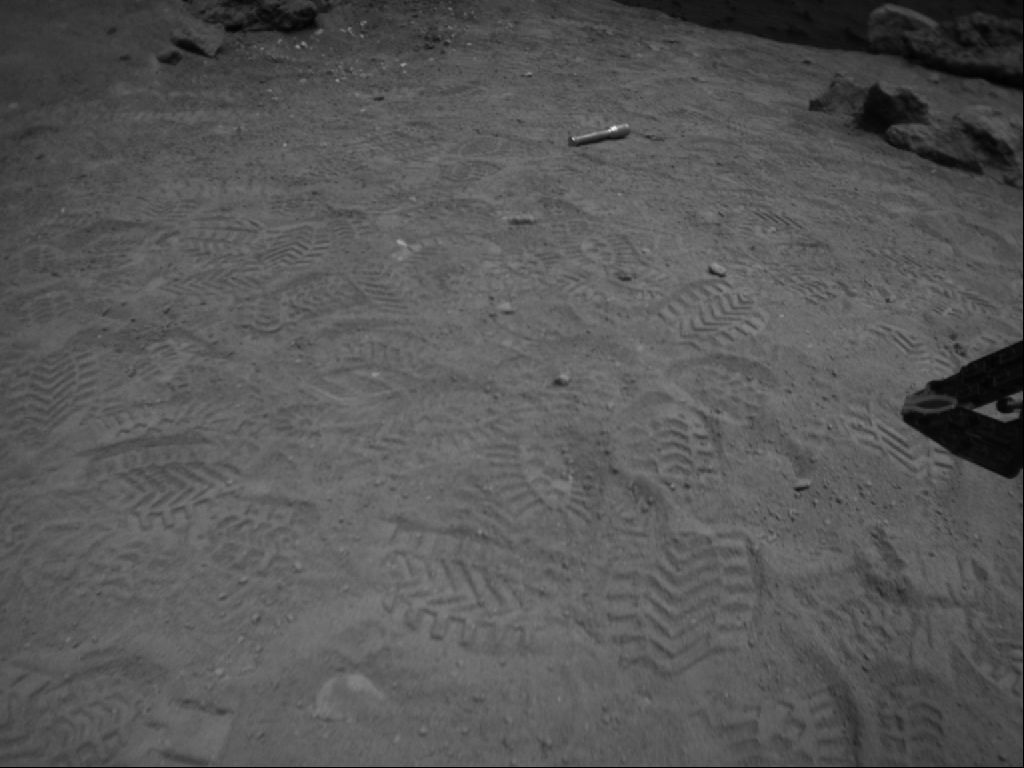

In [6]:
# apenas uma função simples para visualizar as imagens com que estamos a lidar

def imgpath_to_image(path):

    img = Image.open(path)
    return img

img = imgpath_to_image(real_train_list[48])
print(img.format, img.size, img.mode)
img

## **Segundo passo**: Aplicar resize nas images e guardá-las na forma de tensores em X_train_real e X_val_real

In [7]:
# guardar a shape das imagens reais antes do resize

image = cv2.imread(real_valid_list[0], cv2.IMREAD_GRAYSCALE)
shape_before = image.shape
shape_before

(768, 1024)

In [8]:
# função que recebe as paths das imagens como input, aplica o resize e dá
# como output um array dessas imagens

def img_to_array_modified(vector):

  X = []

  for img_path in vector:

      img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      img_arr = cv2.resize(img_arr,(512,384))
      X.append(img_arr)

  return np.array(X)

In [9]:
# criar X_train_real e X_val_real e guardar as shapes depois de aplicada a função acimae

X_train_real = img_to_array_modified(real_train_list)
X_val_real = img_to_array_modified(real_valid_list)

shape_after = (X_train_real.shape[1], X_train_real.shape[2], 1)

print(X_train_real.shape, X_val_real.shape)

(49, 384, 512) (6, 384, 512)


In [10]:
X_train_real[0]

array([[ 12,  13,  15, ..., 112, 106,  52],
       [ 15,  16,  19, ..., 103, 101,  52],
       [ 20,  21,  24, ...,  88,  88,  50],
       ...,
       [ 92,  92,  98, ...,  96,  98,  48],
       [ 98,  98,  99, ...,  94,  97,  48],
       [ 49,  50,  50, ...,  48,  49,  24]], dtype=uint8)

##**Terceiro passo:** Preparar as dataframes de onde se obtém os valores para as bounding boxes das imagens de X_train_real e X_val_real

Estas bounding boxes terão o formato usado com YOLO, i.e.:
**[x_centroid, y_centroid, width, height]** normalizados

De momento têm formato Albumentations: [x_min, y_min, x_max, y_max], tudo normalizado

In [11]:
# preparar a dataframe a partir do csv file que contém as coordenadas das
# bounding boxes de train e val, adaptado para sintético e real
# os nomes das imagens .png serão o índice da df e faremos drop da coluna label

def prepare_df(image_type):

  if image_type == 'real':
    df = pd.read_csv('./train_images/real/real_scene.csv')

  else:
    df = pd.read_csv('./train_images/synthetic/synthetic_scene.csv')

  df.set_index('image', inplace=True)
  df.drop('label', axis=1, inplace=True)

  return df

In [12]:
df_real = prepare_df('real')
df_real

,xmin,ymin,xmax,ymax
image,,,,
Treal_N11.png,418.660017,40.017738,461.220283,53.640798
Treal_N1.png,529.316708,497.241685,604.222776,545.773836
Treal_N12.png,476.541978,421.463415,542.935993,464.035477
Treal_N13.png,854.477140,292.895787,892.781380,323.547672
Treal_N10.png,413.552785,182.208426,458.666667,206.900222
Treal_N14.png,570.174564,482.767184,660.402328,545.773836
Treal_N15.png,525.060682,209.454545,578.686617,249.472284
Treal_N16.png,503.780549,70.669623,550.596841,90.252772
Treal_N17.png,18.593516,193.277162,52.641729,217.117517


In [13]:
# shape_before = (768, 1024), calculado anteriormente

def normalize_df(df):

  for i, column in enumerate(df.columns):

      if column == 'xmin' or column == 'xmax':
        df[column] /= shape_before[1]

      else:
        df[column] /= shape_before[0]

  return df

In [14]:
df_real = normalize_df(df_real)
df_real

,xmin,ymin,xmax,ymax
image,,,,
Treal_N11.png,0.408848,0.052106,0.450410,0.069845
Treal_N1.png,0.516911,0.647450,0.590061,0.710643
Treal_N12.png,0.465373,0.548780,0.530211,0.604213
Treal_N13.png,0.834450,0.381375,0.871857,0.421286
Treal_N10.png,0.403860,0.237251,0.447917,0.269401
Treal_N14.png,0.556811,0.628603,0.644924,0.710643
Treal_N15.png,0.512755,0.272727,0.565124,0.324834
Treal_N16.png,0.491973,0.092018,0.537692,0.117517
Treal_N17.png,0.018158,0.251663,0.051408,0.282705


## **Quarto passo**: Criar y_train_real e y_val_real a partir dos valores alterados e ajustados da dataframe

In [15]:
# a função que se segue a esta célula foi generalizada para a parte sintética do dataset,
# sendo por isso necessário correr previamente o seguinte código para não dar erro

synthetic_train_list = list_from_darknetlabels('synthetic', 'train')
synthetic_valid_list = list_from_darknetlabels('synthetic', 'valid')

In [16]:
# como as imagens de train e valid estão misturadas na dataframe, é necessário
# separá-las em duas dataframes distintas, df_train e df_val

# função que separa a dataframe em duas

def separate_df(list):

  image_index = []

  for line in list:

      if list == real_valid_list or list == synthetic_valid_list:
        reg_ex = "((?<=valid/).*)"

      else:
        reg_ex = "((?<=train/).*)"

      my_regex = re.compile(reg_ex)
      m_1 = my_regex.search(line)
      m_2 = m_1.group(0)
      image_index.append(m_2)

  if list == real_valid_list or list == real_train_list:
    df = df_real.loc[image_index]

  else:
    df = df_synthetic.loc[image_index]

  return df

In [17]:
# cria-se as dataframes df_train_real e df_val_real

df_train_real = separate_df(real_train_list)
df_val_real = separate_df(real_valid_list)
df_val_real[:2]

,xmin,ymin,xmax,ymax
image,,,,
Treal_N5.png,0.660718,0.876940,0.750494,0.962306
Treal_N21.png,0.938357,0.307095,0.965789,0.342572


In [18]:
df_train_real[:5]

,xmin,ymin,xmax,ymax
image,,,,
Treal_N1.png,0.516911,0.647450,0.590061,0.710643
Treal_N2.png,0.708100,0.486696,0.847750,0.620843
Treal_N3.png,0.487947,0.638581,0.570942,0.733925
Treal_N4.png,0.558474,0.840355,0.652405,0.947894
Treal_N6.png,0.566786,0.347007,0.659055,0.414634


In [19]:
# a partir das dataframes criadas, prepara-se o y_train e y_val, em forma de np.array
# função que cria o y_train e y_val, dependendo do input df que se lhe dá

def y_set(df):

  y = []

  for i in range(df.shape[0]):
      vector = []

      for j in range(df.shape[1]):
          vector.append(df.iloc[i,j])

      y.append(vector)

  return np.array(y)

In [20]:
# esta função serve para transformar uma bounding box com coordenadas em formato
#Albu para uma bounding box em formato YOLO

def bboxAlbu_to_YOLO(y_set):

    y_YOLO = []

    for bbox in y_set:

        vector = [0,0,0,0]

        vector[0] = (bbox[0] + bbox[2]) / 2
        vector[1] = (bbox[1] + bbox[3]) / 2
        vector[2] = bbox[2] - bbox[0]
        vector[3] = bbox[3] - bbox[1]

        y_YOLO.append(vector)

    return np.array(y_YOLO)

In [21]:
# esta função executa o contrário da anterior: transforma uma bounding box com
# coordenadas em formato YOLO para uma bounding box em formato Albu

def bboxYOLO_to_Albu(y_set):

    y_Albu = []

    for bbox in y_set:

        vector = [0,0,0,0]

        vector[0] = bbox[0] - bbox[2] / 2
        vector[1] = bbox[1] - bbox[3] / 2
        vector[2] = bbox[2] + vector[0]
        vector[3] = bbox[3] + vector[1]

        y_Albu.append(vector)

    return np.array(y_Albu)

In [22]:
# criar y_train_real e y_val_real, verificando a shape de ambos

y_train_real = bboxAlbu_to_YOLO(y_set(df_train_real))
y_val_real = bboxAlbu_to_YOLO(y_set(df_val_real))
print(y_train_real.shape, y_val_real.shape)

y_train_real[:2], y_val_real[:2]

(49, 4) (6, 4)


(array([[0.55348608, 0.67904656, 0.07315046, 0.0631929 ],
        [0.77792498, 0.5537694 , 0.13965087, 0.13414634]]),
 array([[0.70560578, 0.91962306, 0.08977556, 0.08536585],
        [0.95207294, 0.3248337 , 0.02743142, 0.03547672]]))

**------ Apenas a verificar se está a construir a bounding box num dos exemplos do train -------**

In [23]:
X_train_real[0]

array([[ 12,  13,  15, ..., 112, 106,  52],
       [ 15,  16,  19, ..., 103, 101,  52],
       [ 20,  21,  24, ...,  88,  88,  50],
       ...,
       [ 92,  92,  98, ...,  96,  98,  48],
       [ 98,  98,  99, ...,  94,  97,  48],
       [ 49,  50,  50, ...,  48,  49,  24]], dtype=uint8)

In [24]:
# esta função também pode servir para mostrar uma imagem sem bounding box, basta colocar bbox = []

def show_image_bbox(X_arr, y_arr, new_img_path):

  y_arr_albu = [0,0,0,0]

  if len(y_arr) != 0:
    y_arr_albu[0] = y_arr[0] - y_arr[2] / 2
    y_arr_albu[1] = y_arr[1] - y_arr[3] / 2
    y_arr_albu[2] = y_arr[2] + y_arr_albu[0]
    y_arr_albu[3] = y_arr[3] + y_arr_albu[1]


  # os valores da bbox têm de entrar normalizados
  shape_after = X_arr.shape

  X_arr = cv2.merge([X_arr, X_arr, X_arr])   # para conseguir visualizar uma imagem a cinzento

  bbox_ = copy.deepcopy(y_arr_albu)
  pil_img = tf.keras.utils.array_to_img(X_arr)  # esta função tira a normalização do array (não tem muito problema dado que esta função é apenas para demonstração, no modelo entram os valores normalizados)

  tf.keras.utils.save_img(new_img_path, pil_img)

  if len(bbox_) != 0:
    bbox_[0] *= shape_after[1]
    bbox_[1] *= shape_after[0]
    bbox_[2] *= shape_after[1]
    bbox_[3] *= shape_after[0]

    start_point = (int(bbox_[0]), int(bbox_[1]))
    end_point = (int(bbox_[2]), int(bbox_[3]))

  color = (255,0,0)  # RGB, fica vermelho desta forma
  thickness = 1

  image = cv2.imread('./' + new_img_path)

  if len(bbox_) != 0:
    image = cv2.rectangle(image, start_point, end_point, color, thickness)  # tem de se usar valores inteiros aqui
    image = cv2.putText(image, 'sample', (int(bbox_[0]), int(bbox_[1] - 3)), 0, 0.3, (255,0,0), 1)

  final_img = tf.keras.utils.array_to_img(image)

  return final_img

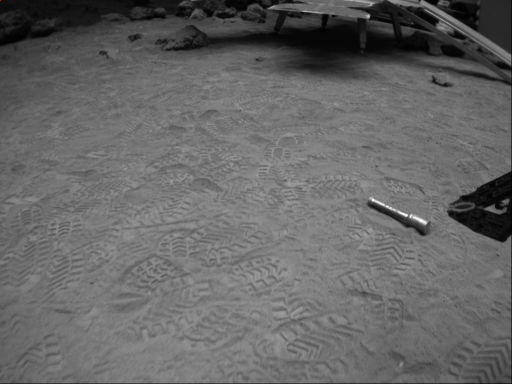

In [25]:
show_image_bbox(X_train_real[1], [], 'tinyTreal_N1.png')

## **Quinto passo**: Criar X_train and X_val ao adicionar a X_train_real and X_val_real a parte sintética do dataset

**--- 1º ---**

In [26]:
# código já corrido lá em cima

synthetic_train_list = list_from_darknetlabels('synthetic', 'train')
synthetic_valid_list = list_from_darknetlabels('synthetic', 'valid')

**--- 2º ---**

In [27]:
# guardar as shapes das imagens de train e valid, que são iguais, antes de darem resize

image = cv2.imread(synthetic_valid_list[0], cv2.IMREAD_GRAYSCALE)
shape_before = image.shape
shape_before

(720, 1280)

In [28]:
X_train_syn = img_to_array_modified(synthetic_train_list)
X_val_syn = img_to_array_modified(synthetic_valid_list)

In [29]:
shape_after = (X_train_syn.shape[1], X_train_syn.shape[2], 1)

print(X_train_syn.shape, X_val_syn.shape)

(542, 384, 512) (60, 384, 512)


**--- 3º ---**

In [30]:
df_synthetic = prepare_df('synthetic')
df_synthetic[:2]

,xmin,ymin,xmax,ymax
image,,,,
Tsyn_N104.png,743.652653,375.965074,773.645762,385.670956
Tsyn_N463.png,761.662246,373.691038,793.351017,396.332547


In [31]:
df_synthetic = normalize_df(df_synthetic)
df_synthetic[:2]

,xmin,ymin,xmax,ymax
image,,,,
Tsyn_N104.png,0.580979,0.522174,0.604411,0.535654
Tsyn_N463.png,0.595049,0.519015,0.619805,0.550462


**--- 4º ---**

In [32]:
df_train_syn = separate_df(synthetic_train_list)
df_val_syn = separate_df(synthetic_valid_list)
df_val_syn[:2]

,xmin,ymin,xmax,ymax
image,,,,
Tsyn_N9.png,0.622498,0.584701,0.657695,0.594517
Tsyn_N15.png,0.316770,0.542983,0.339545,0.556480


In [33]:
y_train_syn = bboxAlbu_to_YOLO(y_set(df_train_syn))
y_val_syn = bboxAlbu_to_YOLO(y_set(df_val_syn))
print(y_train_syn.shape, y_val_syn.shape)

y_train_syn[:2], y_val_syn[:2]

(542, 4) (60, 4)


(array([[0.61732229, 0.50187883, 0.02967564, 0.01349693],
        [0.58730159, 0.57488497, 0.02346446, 0.01717791]]),
 array([[0.64009662, 0.5896089 , 0.03519669, 0.00981595],
        [0.32815735, 0.5497316 , 0.02277433, 0.01349693]]))

**--- 5º ---**

In [34]:
# criar o X_train, X_val, y_train e y_val final com as imagens reais e sintéticas

X_train = np.concatenate([X_train_real, X_train_syn])
y_train = np.concatenate([y_train_real, y_train_syn])
X_val = np.concatenate([X_val_real, X_val_syn])
y_val = np.concatenate([y_val_real, y_val_syn])

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(591, 384, 512) (591, 4) (66, 384, 512) (66, 4)


**----- Apenas a verificar se está a construir a bounding box num dos exemplos do synthetic -----**

In [35]:
X_train[50]

array([[ 63,  79,  65, ..., 107, 119, 114],
       [ 66,  60,  71, ..., 106,  98,  97],
       [ 67,  60,  78, ..., 102, 110,  95],
       ...,
       [ 77,  29,  79, ...,  13,  16,  31],
       [ 90,  48,  67, ...,  12,  17,  16],
       [110,  64,  29, ...,  44,  13,  17]], dtype=uint8)

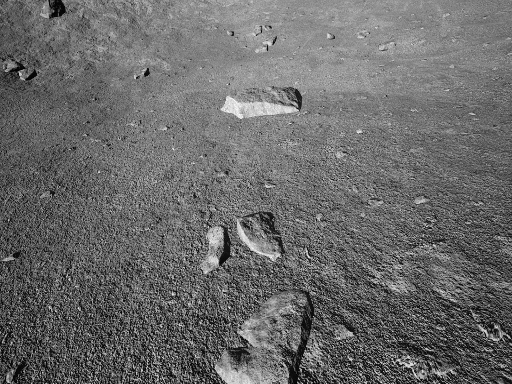

In [36]:
X = X_train[50]
x = cv2.merge([X, X, X])
pil_img = tf.keras.utils.array_to_img(x)
pil_img

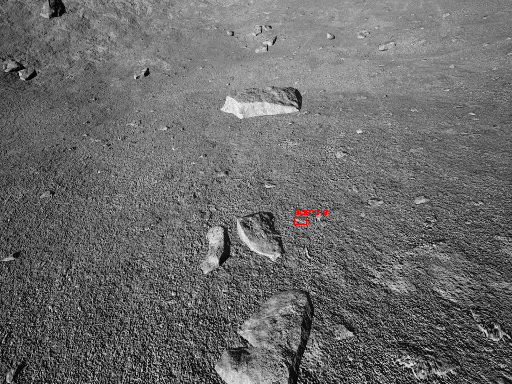

In [37]:
index = 50
show_image_bbox(X_train[index], y_train[index], 'tinyTsyn_N104.png') # está a perder a normalização por causa do cv2.imread()

## **Sexto passo:** Data Augmentation com albumentations.ai

In [38]:
# antes de adicionar as imagens transformadas aos conjuntos, as shapes de X_train e X_valid
# são as seguintes

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(591, 384, 512) (591, 4) (66, 384, 512) (66, 4)


In [39]:
def transform_images(X_set, bbox_set, transform):

    bbox_set = list(bbox_set)
    X_transformed = []
    bbox_transformed = []

    for i in range(len(bbox_set)):

        bbox_set[i] = list(bbox_set[i])
        bbox_set[i].append('sample')

    for i in range(X_set.shape[0]):

        transformed = transform(image=X_set[i], bboxes=[bbox_set[i]])
        transformed_image = transformed['image']
        transformed_bbox = transformed['bboxes']

        X_transformed.append(transformed_image)
        bbox_transformed.append(transformed_bbox)

    for i in range(len(bbox_transformed)):

        if len(bbox_transformed[i]) != 0:
          bbox_transformed[i] = list(bbox_transformed[i][0])
          bbox_transformed[i].remove('sample')

    # retirar as imagens onde o tubo não está presente

    X_train_transf = []
    y_train_transf = []

    for i, bbox in enumerate(bbox_transformed):

        if len(bbox) != 0:
          X_train_transf.append(X_transformed[i])
          y_train_transf.append(bbox)

    return np.array(X_train_transf), np.array(y_train_transf)

In [40]:
# efetuamos três transformações diferentes em todo o X_train e y_train
# no final, fazemos concat dos novos elementos de X_train e y_train

def transformations_and_concat(X_set, y_set):

    reshape_values = (X_set.shape[1], X_set.shape[2])

    random.seed(42)
    transform_1 = A.Compose([A.augmentations.transforms.Solarize(
                             threshold=0.4, p=1),
                             ],
                             bbox_params=A.BboxParams(format='yolo'))

    random.seed(42)
    transform_2 = A.Compose([A.augmentations.transforms.Superpixels(
                             p_replace=0.1, n_segments=100, max_size=500, p=1)
                             ],
                             bbox_params=A.BboxParams(format='yolo'))

    transformed_X_set_1, transformed_y_set_1 = transform_images(X_set, y_set, transform_1)
    transformed_X_set_2, transformed_y_set_2 = transform_images(X_set, y_set, transform_2)


    # para conseguir este concat, é necessário terem todas as mesma shape que X_set

    X_set_final1 = np.concatenate([X_set,
                                  transformed_X_set_1,
                                  transformed_X_set_2,
                                  ])

    y_set_final1 = np.concatenate([y_set,
                                  transformed_y_set_1,
                                  transformed_y_set_2,
                                  ])



    # aplicar random crop a todas as transformações feitas

    random.seed(42)
    transform_3 = A.Compose([A.RandomCrop(width=192, height=144),
                             A.augmentations.geometric.resize.Resize(
                             height = reshape_values[0], width = reshape_values[1]),
                             A.augmentations.geometric.transforms.Affine(scale=1.5, p=1),
                             ],
                             bbox_params=A.BboxParams(format='yolo'))



    transformed_X_final1, transformed_y_final1 = transform_images(
    X_set_final1, y_set_final1, transform_3)


    X_set_final2 = np.concatenate([X_set_final1,
                                   transformed_X_final1])

    y_set_final2 = np.concatenate([y_set_final1,
                                   transformed_y_final1])

    return np.array(X_set_final2), np.array(y_set_final2)

In [41]:
X_train_regression, y_train_regression = transformations_and_concat(X_train, y_train)
X_val_regression, y_val_regression = X_val, y_val

print(X_train_regression.shape, y_train_regression.shape,
      X_val_regression.shape, y_val_regression.shape)

(2071, 384, 512) (2071, 4) (66, 384, 512) (66, 4)


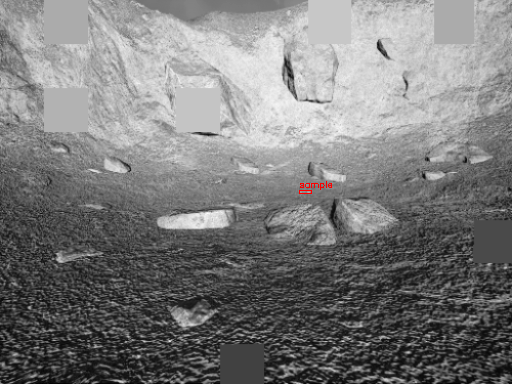

In [42]:
index = 1700
show_image_bbox(X_train_regression[index], y_train_regression[index], 'transformed_image.png')

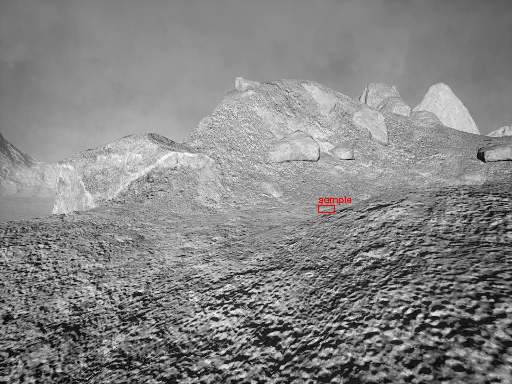

In [43]:
index = 60
show_image_bbox(X_val_regression[index], y_val_regression[index], 'transformed_image.png')

#**Preprocessing para o modelo de deteção da sample (verifica apenas se a sample está na imagem dada ou não)**

**As coordenadas das bounding box que demos para as imagens sem o tubo apanham a imagem toda porque as únicas imagens que a "albumentations" deixa passar são aquelas que contêm pelo menos uma parte da bounding box; mais à frente, depois da transformação, iremos mudar essas coordenadas para NaN values**

In [44]:
y_train.shape, y_val.shape

((591, 4), (66, 4))

In [45]:
# esta função toma como input imagens de X_train ou X_val, assim como as
# coordenadas das bounding boxes e retorna as mesmas imagens, mas sem a sample

def erase_sample(X_set, y_set):

    X_set_erased_sample = []
    y_set_erased_sample = []

    y_set_albu = bboxYOLO_to_Albu(y_set)
    current_shape = X_set[0].shape

    for i, bbox in enumerate(y_set_albu):

        mask = np.zeros(current_shape, dtype=np.uint8)

        bbox_ = copy.deepcopy(bbox)
        bbox_[0] *= current_shape[1]
        bbox_[1] *= current_shape[0]
        bbox_[2] *= current_shape[1]
        bbox_[3] *= current_shape[0]

        x_points = (int(bbox_[0]), int(bbox_[2]))
        y_points = (int(bbox_[1]), int(bbox_[3]))

        mask[y_points[0]:y_points[1], x_points[0]:x_points[1]] = 255
        masked_image = cv2.bitwise_and(X_set[i], X_set[i], mask = mask)
        X_set_erased_sample.append(cv2.inpaint(X_set[i], masked_image, 3, cv2.INPAINT_TELEA))

        y_set_erased_sample.append([0.5, 0.5, 1, 1])

    return np.array(X_set_erased_sample), np.array(y_set_erased_sample)

In [46]:
X_train_erased_sample, y_train_erased_sample = erase_sample(X_train, y_train)
X_val_erased_sample, y_val_erased_sample = erase_sample(X_val, y_val)

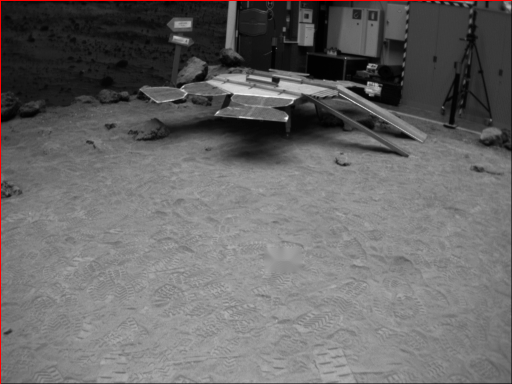

In [47]:
show_image_bbox(X_train_erased_sample[0], y_train_erased_sample[0], 'erased_sample.png')

In [48]:
# efetuamos apenas um zoom e crop nestas imagens sem tubo e no final damos
# concat dessas novas imagens com as originais sem tubo

def crop_zoom_transformations_and_concat(X_set, y_set):

    reshape_values = (X_set.shape[1], X_set.shape[2])

    random.seed(42)
    transform_1 = A.Compose([A.RandomCrop(width=192, height=144),
                             A.augmentations.geometric.resize.Resize(
                             height = reshape_values[0], width = reshape_values[1]),
                             A.augmentations.geometric.transforms.Affine(scale=1.5, p=1),
                             ],
                             bbox_params=A.BboxParams(format='yolo'))

    transformed_X_set, transformed_y_set = transform_images(X_set, y_set, transform_1)


    # para conseguir este concat, é necessário terem todas as mesma shape que X_set

    X_set_final = np.concatenate([X_set, transformed_X_set])
    y_set_final = np.concatenate([y_set, transformed_y_set])

    return np.array(X_set_final), y_set_final

In [49]:
### Primeira parte (conjuntos de treino) ###

# aplicar as transformações a X_train_erased_sample
X_train_erased, _ = crop_zoom_transformations_and_concat(X_train_erased_sample,
                                                         y_train_erased_sample)

# aplicar as transformações a X_train e y_train
X_train_not_erased, y_train_not_erased = crop_zoom_transformations_and_concat(X_train, y_train)


# mudar os valores das bboxes das imagens de X_train_erased para NaN
y_train_null = []
for i in range(len(X_train_erased)):
    y_train_null.append([np.nan] * 4)
y_train_erased = np.array(y_train_null)


# criar X_train_detection e y_train_detection
X_train_detection = np.concatenate([X_train_not_erased, X_train_erased])
y_train_detection = np.concatenate([y_train_not_erased, y_train_erased])


### Segunda parte (conjuntos de validação) ###

# mudar os valores das bboxes das imagens de X_val_erased para NaN
y_train_null = []
for i in range(len(X_val_erased_sample)):
    y_train_null.append([np.nan] * 4)
y_val_erased = np.array(y_train_null)


# criar X_val_detection e y_val_detection
X_val_detection = np.concatenate([X_val, X_val_erased_sample])
y_val_detection = np.concatenate([y_val, y_val_erased])

print(X_train_detection.shape, y_train_detection.shape,
      X_val_detection.shape, y_val_detection.shape)

(1872, 384, 512) (1872, 4) (132, 384, 512) (132, 4)


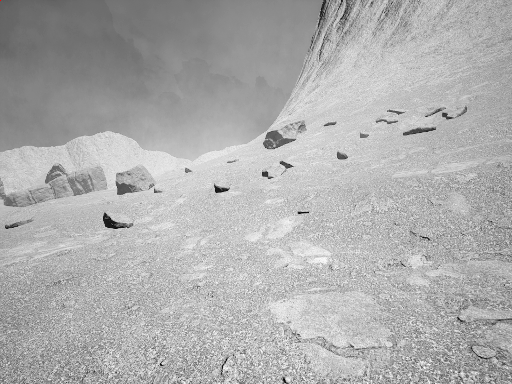

In [50]:
show_image_bbox(X_train_detection[590], [], 'erased_sample.png')

#**Guardar as imagens de cada Preprocessing numa pasta à parte: organized_data_gray**

In [ ]:
!mkdir organized_data_gray
!mkdir organized_data_gray/train
!mkdir organized_data_gray/valid

!mkdir organized_data_gray/train/X_train_regression
!mkdir organized_data_gray/train/X_train_detection
!mkdir organized_data_gray/valid/X_valid_regression
!mkdir organized_data_gray/valid/X_valid_detection

In [ ]:
# criar duas dataframes para y_train e y_val e depois passar para csv file

df_train_regression = pd.DataFrame(y_train_regression, columns=['x_center_norm',
                                                                'y_center_norm',
                                                                'width_norm',
                                                                'height_norm'])

df_valid_regression = pd.DataFrame(y_val_regression, columns=['x_center_norm',
                                                              'y_center_norm',
                                                              'width_norm',
                                                              'height_norm'])

df_train_detection = pd.DataFrame(y_train_detection, columns=['x_center_norm',
                                                              'y_center_norm',
                                                              'width_norm',
                                                              'height_norm'])

df_valid_detection = pd.DataFrame(y_val_detection, columns=['x_center_norm',
                                                            'y_center_norm',
                                                            'width_norm',
                                                            'height_norm'])

df_train_regression.to_csv('./organized_data_gray/train/y_train_regression.csv',
                           index=False)

df_valid_regression.to_csv('./organized_data_gray/valid/y_val_regression.csv',
                           index=False)

df_train_detection.to_csv('./organized_data_gray/train/y_train_detection.csv',
                          index = False)

df_valid_detection.to_csv('./organized_data_gray/valid/y_val_detection.csv',
                          index = False)

In [ ]:
for i, arr in enumerate(X_val_regression):
  tf.keras.utils.save_img('./organized_data_gray/valid/X_valid_regression/processed_validimage_' + str(i) + '.png',
                          cv2.merge([arr, arr, arr]))

for i, arr in enumerate(X_train_regression):
  tf.keras.utils.save_img('./organized_data_gray/train/X_train_regression/processed_trainimage_' + str(i) + '.png',
                          cv2.merge([arr, arr, arr]))

In [ ]:
for i, arr in enumerate(X_val_detection):
  tf.keras.utils.save_img('./organized_data_gray/valid/X_valid_detection/processed_validimage_' + str(i) + '.png',
                          cv2.merge([arr, arr, arr]))

for i, arr in enumerate(X_train_detection):
  tf.keras.utils.save_img('./organized_data_gray/train/X_train_detection/processed_trainimage_' + str(i) + '.png',
                          cv2.merge([arr, arr, arr]))

#**Preprocessing das imagens de teste para avaliarem o modelo final**

##**Criar X_test, y_test**

In [51]:
def list_from_test_darknetlabels(i):

  f = open('./field_tests_images/darknet_labels/field_test' + str(i) + '_valid.txt', 'r')
  lines_list = f.readlines()
  f.close()

  vector = []

  for line in lines_list:

      my_regex = re.compile("((?<=datasets/).*).png")   # positive lookbehind
      m_1 = my_regex.search(line)
      m_2 = m_1.group(0)
      path = './' + m_2
      vector.append(path)

  return vector

In [52]:
test_list_1 = list_from_test_darknetlabels(1)
test_list_2 = list_from_test_darknetlabels(2)

print(len(test_list_1), len(test_list_2))
test_list_1[:2]

1128 1756


['./field_tests_images/test1/loccam_left/Etest1_Cloccam_Pleft_N1_T00-00-000.png',
 './field_tests_images/test1/loccam_left/Etest1_Cloccam_Pleft_N2_T00-00-163.png']

In [53]:
image = cv2.imread(test_list_1[0], cv2.IMREAD_GRAYSCALE)     # é necessário para ter apenas um canal e não 3 canais de cor
shape_before = image.shape
shape_before

(768, 1024)

In [54]:
X_test_1 = img_to_array_modified(test_list_1)
X_test_2 = img_to_array_modified(test_list_2)

In [55]:
X_test = np.concatenate([X_test_1, X_test_2])
shape_after = (X_test.shape[1], X_test.shape[2], 1)
print(X_test.shape)

(2884, 384, 512)


In [56]:
def prepare_test_df(test_set, camera):

  df = pd.read_csv('./field_tests_images/test' + str(test_set) + '/test' + str(test_set) + '_' + camera + '.csv')

  df.set_index('image', inplace=True)
  df.drop('label', axis=1, inplace=True)

  return df

In [57]:
df1 = prepare_test_df(1, 'loccam_left')
df2 = prepare_test_df(1, 'loccam_right')
df3 = prepare_test_df(1, 'navcam_left')
df4 = prepare_test_df(1, 'navcam_right')

df5 = prepare_test_df(2, 'loccam_left')
df6 = prepare_test_df(2, 'loccam_right')
df7 = prepare_test_df(2, 'navcam_left')
df8 = prepare_test_df(2, 'navcam_right')

In [58]:
df1_norm = normalize_df(df1)
df2_norm = normalize_df(df2)
df3_norm = normalize_df(df3)
df4_norm = normalize_df(df4)

df5_norm = normalize_df(df5)
df6_norm = normalize_df(df6)
df7_norm = normalize_df(df7)
df8_norm = normalize_df(df8)

In [59]:
df_norm = pd.concat([df1_norm, df2_norm, df3_norm, df4_norm,
                     df5_norm, df6_norm, df7_norm, df8_norm])
print(df_norm.shape)
df_norm[:2]

(2060, 4)


,xmin,ymin,xmax,ymax
image,,,,
Etest1_Cloccam_Pleft_N101_T00-31-051.png,0.878507,0.158537,0.915082,0.192905
Etest1_Cloccam_Pleft_N100_T00-30-840.png,0.879338,0.162971,0.914251,0.192905


In [60]:
images_without_txt = []
all_files = []
count = 0

all_files.extend(os.listdir('./field_tests_images/test1/loccam_left'))
all_files.extend(os.listdir('./field_tests_images/test1/loccam_right'))
all_files.extend(os.listdir('./field_tests_images/test1/navcam_left'))
all_files.extend(os.listdir('./field_tests_images/test1/navcam_right'))
all_files.extend(os.listdir('./field_tests_images/test2/loccam_left'))
all_files.extend(os.listdir('./field_tests_images/test2/loccam_right'))
all_files.extend(os.listdir('./field_tests_images/test2/navcam_left'))
all_files.extend(os.listdir('./field_tests_images/test2/navcam_right'))

for file in all_files:

    image_txt = file.split('.')[0] + '.txt'
    image = file.split('.')[0] + '.png'

    if image_txt not in all_files:
      images_without_txt.append(image)
      count += 1

count, images_without_txt[:5]

(824,
 ['Etest1_Cloccam_Pleft_N4_T00-00-606.png',
  'Etest1_Cloccam_Pleft_N44_T00-12-828.png',
  'Etest1_Cloccam_Pleft_N43_T00-12-560.png',
  'Etest1_Cloccam_Pleft_N46_T00-13-802.png',
  'Etest1_Cloccam_Pleft_N42_T00-12-341.png'])

In [61]:
for i in images_without_txt:
    df_norm.loc[i] = [np.nan] * 4

In [62]:
print(df_norm.shape)
df_norm

(2884, 4)


,xmin,ymin,xmax,ymax
image,,,,
Etest1_Cloccam_Pleft_N101_T00-31-051.png,0.878507,0.158537,0.915082,0.192905
Etest1_Cloccam_Pleft_N100_T00-30-840.png,0.879338,0.162971,0.914251,0.192905
Etest1_Cloccam_Pleft_N102_T00-31-284.png,0.871857,0.155211,0.915913,0.188470
Etest1_Cloccam_Pleft_N103_T00-31-607.png,0.875182,0.148559,0.913420,0.188470
Etest1_Cloccam_Pleft_N104_T00-31-905.png,0.872688,0.152993,0.906770,0.186253
...,...,...,...,...
Etest2_Cnavcam_Pright_N91_T00-25-387.png,NaN,NaN,NaN,NaN
Etest2_Cnavcam_Pright_N94_T00-26-127.png,NaN,NaN,NaN,NaN
Etest2_Cnavcam_Pright_N93_T00-25-876.png,NaN,NaN,NaN,NaN


In [63]:
test_list = test_list_1 + test_list_2
len(test_list)

2884

In [64]:
y_test = []
for image_path in test_list:

    index = image_path.split('/')[4]
    vector = []

    for j in range(df_norm.shape[1]):

      vector.append(df_norm.loc[index, df_norm.columns[j]])

    y_test.append(vector)

y_test = np.array(y_test)
y_test = bboxAlbu_to_YOLO(y_test)

In [65]:
y_test

array([[0.98698566, 0.15853659, 0.02244389, 0.02217295],
       [0.97950436, 0.154102  , 0.02078138, 0.02660754],
       [0.97410121, 0.15133038, 0.02327515, 0.0210643 ],
       ...,
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan]])

##**Ver se as imagens correspondem às suas bounding boxes**

In [66]:
# experimentar isto para ver quais índices funcionam
try:
  index = 100
  show_image_bbox(X_test[index], y_test[index], 'okok.png')
except ValueError:
  print('There is no sample in this image')

In [67]:
# correr esta célula com o valor dado na variável index anterior, caso não dê erro, de modo a ver imagem
#show_image_bbox(X_test[index], y_test[index], 'okok.png')

#**Guardar as imagens retiradas dos ficheiros e pastas de teste numa pasta diretamente acessível**

In [ ]:
!mkdir ./organized_data_gray/test
!mkdir ./organized_data_gray/test/X_test_images

In [ ]:
dataframe_test = pd.DataFrame(y_test, columns=['x_center_norm',
                                                'y_center_norm',
                                                'width_norm', 'height_norm'])
dataframe_test.to_csv('./organized_data_gray/test/y_test.csv', index=False)

In [ ]:
for i, arr in enumerate(X_test):
  tf.keras.utils.save_img('./organized_data_gray/test/X_test_images/processed_testimage_' + str(i) + '.png', cv2.merge([arr, arr, arr]))

#**------------------------------- Preprocessing acaba aqui ----------------------------------**

##**YOLOv8** para este dataset

In [ ]:
X_train.shape

(591, 384, 512)

In [ ]:
X_train_erased_sample.shape

(591, 384, 512)

In [93]:
!pip install ultralytics
from ultralytics import YOLO
import yaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.2/614.2 kB 5.7 MB/s eta 0:00:00


In [ ]:
X_train[0].shape

(384, 512)

In [ ]:
# acho que para o yolo o y_train e y_val dos que não têm bounding box não entra no conjunto
X_train_yolo = np.concatenate([X_train, X_train_erased_sample])
y_train_yolo = y_train
X_val_yolo = X_val_detection
y_val_yolo = y_val

In [73]:
ls = list(y_test)
ls2 = []
for arr in ls:
  arr = list(arr)
  ls2.append(arr)

In [74]:
index = []
for i, y in enumerate(ls2):
  if np.isnan(y[0]):
    index.append(i)

In [75]:
len(index)

824

In [80]:
len(y_test)

2884

In [100]:
y_test_new = []
X_test_new = []

for i in range(0, len(X_test)):
  if i not in index:
    y_test_new.append(y_test[i])
    X_test_new.append(X_test[i])

y_test_new = np.array(y_test_new)

In [101]:
y_test_new.shape

(2060, 4)

In [102]:
for i in range(0, len(X_test)):
  if i in index:
    X_test_new.append(X_test[i])

X_test_new = np.array(X_test_new)

In [103]:
X_test_new.shape

(2884, 384, 512)

In [104]:
X_test_yolo = X_test_new
y_test_yolo = y_test_new

X_test_yolo.shape, y_test_yolo.shape

((2884, 384, 512), (2060, 4))

In [ ]:
X_train_yolo.shape, y_train_yolo.shape, X_val_yolo.shape, y_val_yolo.shape

((1182, 384, 512), (591, 4), (132, 384, 512), (66, 4))

In [106]:
!mkdir ./yolo
!mkdir ./yolo/train
!mkdir ./yolo/train/images
!mkdir ./yolo/train/labels

!mkdir ./yolo/valid
!mkdir ./yolo/valid/images
!mkdir ./yolo/valid/labels

!mkdir ./yolo/test
!mkdir ./yolo/test/images
!mkdir ./yolo/test/labels

mkdir: cannot create directory ‘./yolo’: File exists
mkdir: cannot create directory ‘./yolo/train’: File exists
mkdir: cannot create directory ‘./yolo/train/images’: File exists
mkdir: cannot create directory ‘./yolo/train/labels’: File exists
mkdir: cannot create directory ‘./yolo/valid’: File exists
mkdir: cannot create directory ‘./yolo/valid/images’: File exists
mkdir: cannot create directory ‘./yolo/valid/labels’: File exists
mkdir: cannot create directory ‘./yolo/test’: File exists
mkdir: cannot create directory ‘./yolo/test/images’: File exists
mkdir: cannot create directory ‘./yolo/test/labels’: File exists


In [ ]:
for i, arr in enumerate(X_val_yolo):
  tf.keras.utils.save_img('./yolo/valid/images/' + str(i) + '.png', cv2.merge([arr, arr, arr]))

for i, arr in enumerate(X_train_yolo):
  tf.keras.utils.save_img('./yolo/train/images/' + str(i) + '.png', cv2.merge([arr, arr, arr]))

In [ ]:
for i, bbox in enumerate(y_train_yolo):
  f = open('./yolo/train/labels/' + str(i) + '.txt', 'w')
  f.write('0 ' + str(bbox[0]) + ' ' + str(bbox[1]) + ' ' + str(bbox[2]) + ' ' + str(bbox[3]))
  f.close()

for i, bbox in enumerate(y_val_yolo):
  f = open('./yolo/valid/labels/' + str(i) + '.txt', 'w')
  f.write('0 ' + str(bbox[0]) + ' ' + str(bbox[1]) + ' ' + str(bbox[2]) + ' ' + str(bbox[3]))
  f.close()

In [107]:
for i, arr in enumerate(X_test_yolo):
  tf.keras.utils.save_img('./yolo/test/images/' + str(i) + '.png', cv2.merge([arr, arr, arr]))

for i, bbox in enumerate(y_test_yolo):
  f = open('./yolo/test/labels/' + str(i) + '.txt', 'w')
  f.write('0 ' + str(bbox[0]) + ' ' + str(bbox[1]) + ' ' + str(bbox[2]) + ' ' + str(bbox[3]))
  f.close()

In [91]:
f = open('./data.yaml', 'w')
f.write("""
path: /content/drive/MyDrive/Mars_Capstone_Project/MarsSampleLocalization_Dataset
train: yolo/train/images
val: yolo/test/images

nc: 1
names:
  0: sample
""")
f.close()

In [ ]:
model = YOLO()
model.train(data='data.yaml', epochs=5)

Ultralytics YOLOv8.0.171 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a4400d368f0>
fitness: 0.13666952091816006
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.12141])
names: {0: 'sample'}
plot: False
results_dict: {'metrics/precision(B)': 0.6507541262830299, 'metrics/recall(B)': 0.25419222573058825, 'metrics/mAP50(B)': 0.2740271273191126, 'metrics/mAP50-95(B)': 0.12140756465138755, 'fitness': 0.13666952091816006}
save_dir: PosixPath('runs/detect/train10')
speed: {'preprocess': 1.4790007562348337, 'inference': 186.0255111347545, 'loss': 0.00013004649769176135, 'postprocess': 0.8866696646719268}

In [108]:
# para validar o modelo YOLO já treinado, usa-se o seguinte comando

!yolo task=detect mode=val model='./runs/detect/train10/weights/best.pt' data='./data.yaml'

Ultralytics YOLOv8.0.173 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/Mars_Capstone_Project/MarsSampleLocalization_Dataset/yolo/test/labels.cache... 2060 images, 824 backgrounds, 0 corrupt: 100% 2884/2884 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 181/181 [11:09<00:00,  3.70s/it]
                   all       2884       2060      0.843      0.723      0.796       0.39
Speed: 6.1ms preprocess, 206.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val5


In [ ]:
# para testar o modelo YOLO com o test set, usa-se o seguinte comando

!yolo task=detect mode=predict model='./runs/detect/train6/weights/best.pt' conf=0.25 source='./organized_data_gray/test/X_test_images'